## План работы

[1. Изучение общей информации из файла с данными](#1.)<br>
[2. Подготовка данных](#2.)<br>
[3. Исследование задачи](#3.)<br>
[4. Борьба с дисбалансом](#4.)<br>
[5. Тестирование модели](#5.)<br>

# 1. Изучение общей информации из файла с данными <a id = "1."> </a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

warnings.filterwarnings('ignore') 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
%matplotlib inline

data = pd.read_csv(r'E:\Документы прочие\IT\Яндекс практикум\Project\6 Обучение с учителем\Churn.csv')

def data_info(data):
    '''
    Функция принимает в качестве аргумента датасет.
    Фукнция выводит информацию о датасете и первые 10 строк датасета.
    '''
    data.info()
    display(data.head(10))
    
def upsample(features, target, repeat):
    '''
    Функция принимает в качестве аргументов: колонки с признаками и целевым признаком обучающей выборки, кратность увеличения.
    Функция увеличивает размер положительного класса (1) с меньшим количеством объектов.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    '''
    Функция принимает в качестве аргументов: колонки с признаками и целевым признаком обучающей выборки, кратность уменьшения.
    Функция уменьшает размер отрицательного класса (0) с большим количеством объектов.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

def ml(model, features_train, target_train, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак выборки для обучения и тестирования.
    Функция обучает заданную модель по обучающей выборке и расчитывает метрики по тестовой выборке: accuracy, F1-меру.
    '''
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    print('Точность модели:{:.2%}'. format(accuracy))
    print('F1-мера: {:.4f}'. format(f1_score(target_valid, predictions)))

def roc(model, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак для тестирования.
    Функция строит ROC-кривую модели, ROC-кривую случайной модели модели и высчитывает AUC-ROC.
    '''
    #расчитываем fpr и tpr
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure(figsize = (15,10))
    # ROC-кривая нашей модели
    plt.plot(fpr, tpr, linestyle='-')
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('ROC-кривая')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.show()
    # вычисляем AUC_ROC
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('AUC-ROC: {:.2f}'.format(auc_roc))
    
def rfc_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами для модели случайного леса.
    '''
    model = RandomForestClassifier(random_state=12345)
    param_grid = {
        'random_state': [12345],
        'n_estimators': range(1,16,2),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : range(1,16,1),
        'criterion' :['gini', 'entropy']
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3, scoring = 'f1')
    CV.fit(features, target)
    return CV.best_params_

def rfc_gridsearchcv_balanced(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами для модели случайного леса с автоматическим балансированием классов.
    '''
    model = RandomForestClassifier(random_state=12345)
    param_grid = {
        'random_state': [12345],
        'n_estimators': range(1,16,2),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : range(1,16,1),
        'criterion' :['gini', 'entropy'],
        'class_weight' : ['balanced', 'balanced_subsample']
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3, scoring = 'f1')
    CV.fit(features, target)
    return CV.best_params_

def lr_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами для модели логистической регрессии.
    '''
    model = LogisticRegression(random_state=12345)
    param_grid = { 
        'random_state': [12345],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2']
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3, scoring = 'f1')
    CV.fit(features_train, target_train)
    return CV.best_params_

def lr_gridsearchcv_balanced(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами для модели логистической регрессии с автоматическим балансированием классов.
    '''
    model = LogisticRegression(random_state=12345)
    param_grid = { 
        'random_state': [12345],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'class_weight' : ['balanced']
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3, scoring = 'f1')
    CV.fit(features_train, target_train)
    return CV.best_params_

Для анализа мы будем использовать датасет: Churn.

In [2]:
data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       10000 non-null  int64  
 1   RowNumber        10000 non-null  int64  
 2   CustomerId       10000 non-null  int64  
 3   Surname          10000 non-null  object 
 4   CreditScore      10000 non-null  int64  
 5   Geography        10000 non-null  object 
 6   Gender           10000 non-null  object 
 7   Age              10000 non-null  int64  
 8   Tenure           9091 non-null   float64
 9   Balance          10000 non-null  float64
 10  NumOfProducts    10000 non-null  int64  
 11  HasCrCard        10000 non-null  int64  
 12  IsActiveMember   10000 non-null  int64  
 13  EstimatedSalary  10000 non-null  float64
 14  Exited           10000 non-null  int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 1.1+ MB


,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Описание данных датасета Churn:
##### Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

##### Целевой признак
- Exited — факт ухода клиента

Колонка Tenure с данными по количеству недвижимости у клиента содержит пропуски. Проанализируем ее значения.

In [3]:
display(data['Tenure'].value_counts())

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Так как колонка содержит данные о клиентах, у которых нет недвижимости, можно сделать вывод о том, что пропуски связаны с отсутствием информации об этих клиентах. Данные не возможно восстановить по имеющейся информации. В случае заполнения этих пропусков случайными значениями или нулями мы можем в результате повлиять на обучение модели. Удалим пропуски из таблицы.

In [4]:
data = data.dropna(subset = ['Tenure'])

### Вывод

Была изучена общая информация о полученных данных. Таблица Churn размером в 10000 строк состоит из 14 колонок и содержит данные 3-х типов: float64, int64 и object. Пропуски в колонке Tenure были успешно удалены.

# 2. Подготовка данных <a id = "2."> </a>

#### Очистим дынные от избыточных признаков

Датасет содержит колонки RowNumber, CustomerId, Surname. RowNumber, CustomerId могут негативно повлиять на обучение модели, так как они относятся к количественным признакам и модель будет пытаться найти их зависимость с целевым признаком, которой нет. Данные несут информативный характер о номере строки и уникальном ID клиента. Тоже самое касается признака Surname. Этот признак категориальный и его не имеет смысла кодировать, так как он обозначает только имя клиента и не влияет на целевой признак. Уберем колонки из нашего датасета.

In [5]:
data_enc = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

#### Закодируем категориальные признаки и масштабируем количественные

Преобразованные данные все еще содержат категориальные признаки Geography и Gender, которые необходимо закодировать для дальнейшего обучения модели. Для этого используем технику прямого кодирования One-Hot Encoding. Для того, чтобы не попасть в дамми-ловушку (ловушку фиктивных признаков) удалим 1 столбец методом drop_first.

In [6]:
data_enc = pd.get_dummies(data_enc, drop_first=True)

В данных присутствуют колличественные признаки с разными разбросами значений. Для того, чтобы алгоритм не решил, что признаки с
большими значениями и разбросом важнее, маштабируем количественные признаки с помощью стандартизации данных.

In [7]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = MinMaxScaler()
scaler.fit(data_enc[numeric])
data_enc[numeric] = scaler.transform(data_enc[numeric])

#### Веделим из данных тестовую выборку

Для дальнейшего тестирования моделей мы выделим из данных тестовую выборку в размере 25% от всех данных.

In [8]:
# выделим тестовую выборку из исходных данных
data_enc_train, data_enc_valid = train_test_split(data_enc, test_size = .25, random_state = 12345)

### Вывод

Было проведена очистка датасета от избыточных признаков. Также мы закодировали категориальные признаки и провели масштабирование количественных признаков. Из датасета была выделена выборка для тестирования моделей.

# 3. Исследование задачи <a id = "3."> </a>

Задача, которую необходимо решить, относится к задаче с двоичной классификацией, так как ее целевой признак состоит из 2-х категорий (клиент ушел или остался). Нам понадобится обучить модель и подобрать для нее наилучшие гиперпараметры. Для этого выделим у обучающей и тестовой выборки признаки и целевой признак.

In [9]:
# разобьем данные обучающей выборки
features_train = data_enc_train.drop(['Exited'], axis = 1)
target_train = data_enc_train['Exited']
# разобьем данные тестовой выборки
features_valid = data_enc_valid.drop(['Exited'], axis = 1)
target_valid = data_enc_valid['Exited']

Проанализируем дисбаланс классов обучающей выборки.

In [10]:
cls_count = data_enc_train['Exited'].value_counts()
display(cls_count)

0    5415
1    1403
Name: Exited, dtype: int64

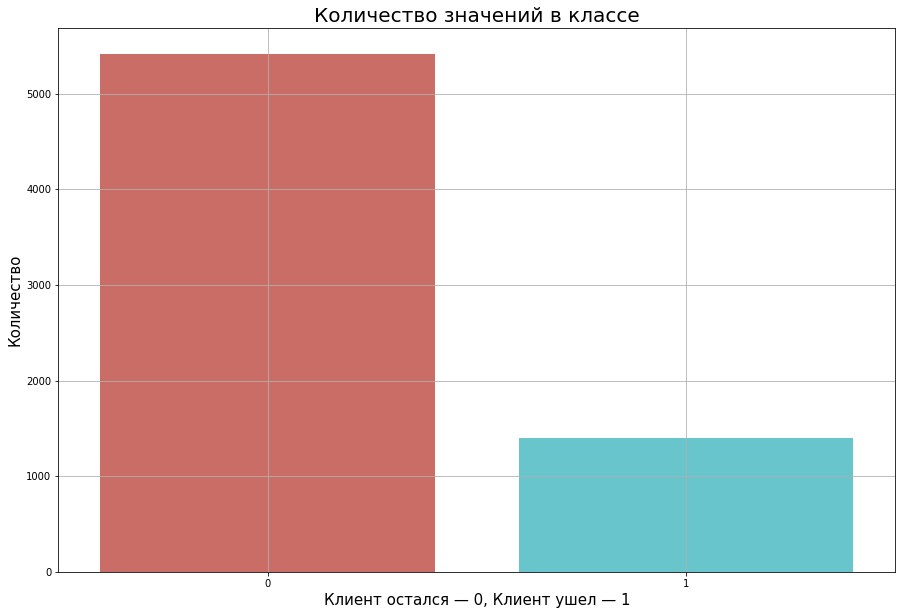

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(x='Exited', data = data_enc_train, palette = 'hls')
plt.title('Количество значений в классе',fontsize=20)
plt.xlabel('Клиент остался — 0, Клиент ушел — 1', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.grid(True)
plt.show()

Наблюдается 4-х кратный дисбаланс классов в обучающей выборке. Обучим те модели, которые предназначены для решения задач классификации без учета дисбаланса классов и проанализируем их метрики.

#### Случайный лес

Используем алгоритм "случайный лес" вместо "дерева решений" для того, чтобы достичь лучшего результата предсказания и избежать переобучения. Подберем для модели наилучшие гиперпараметры.

In [12]:
best_params_rfc = rfc_gridsearchcv(features_train, target_train)
display(best_params_rfc)

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 7,
 'random_state': 12345}

Мы выделилил наилучшие гиперпараметры. Обучим модель с их помощью и проанализируем метрики модели. В связи с наличием дисбаланса в классах в качестве метрики будем использовать F1-меру и ROC-кривую.

In [13]:
model_rfc = RandomForestClassifier(**best_params_rfc)
model_rfc.fit(features_train, target_train)
predictions_rfc = model_rfc.predict(features_valid)
print('F1-мера: {:.4f}'. format(f1_score(target_valid, predictions_rfc)))

F1-мера: 0.5426


F1-мера показывает нам прогнозирование класса на среднем уровне. Проанализируем ROC-кривую и площадь под ней.

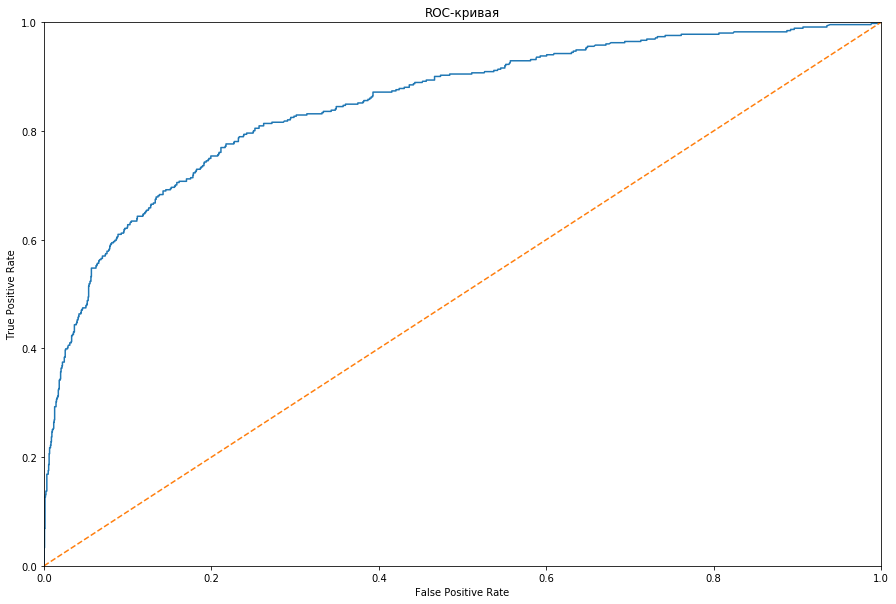

AUC-ROC: 0.85


In [14]:
roc(model_rfc, features_valid, target_valid)

ROC-кривая демонстрирует хорошее качество модели (доля истинно положительных ответов больше доли ложноположительных ответов), так как она выше, чем случайная модель, это также подвтерждается (AUC-ROC) площадью фигуры под кривой, которая близка к единице.

#### Логистическая регрессия

Как альтернативу "случайному лесу" используем алгоритм "логистической регрессии". Подберем для модели наилучшие гиперпараметры.

In [15]:
best_params_lr = lr_gridsearchcv(features_train, target_train)
display(best_params_lr)

{'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear'}

In [16]:
model_lr = LogisticRegression(**best_params_lr)
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
print('F1-мера: {:.4f}'. format(f1_score(target_valid, predictions_lr)))

F1-мера: 0.2978


F1-мера показывает нам слабый уровень прогнозирование класса и меньший, чем у случайного леса. Проанализируем ROC-кривую и площадь под ней.

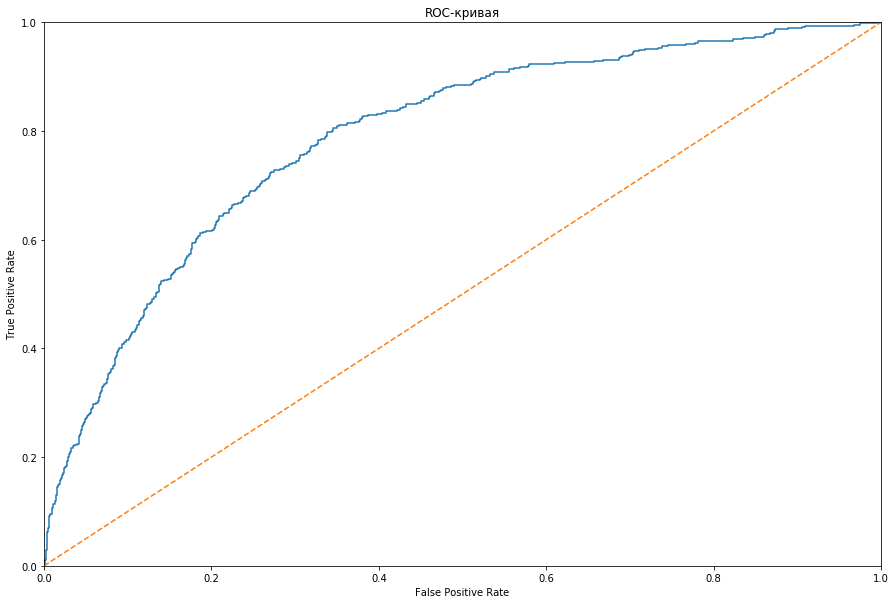

AUC-ROC: 0.79


In [17]:
roc(model_lr, features_valid, target_valid)

ROC-кривая демонстрирует хорошее качество модели, так как она выше чем случайная модель, однако качество модели хуже, чем у случайного леса.

### Вывод

Мы обучили и проанализировали 2 вида моделей. Наилучшую степень прогнозирования, а также наилучшее качество показала модель случайного леса.

# 4. Борьба с дисбалансом <a id = "4."> </a>

Для того, чтобы справится с дисбалансом классов существуют различные методы. Проанализируем влияние каждого метода балансирования на метрики наших моделей. 

### 1) Взвешивание классов

Для балансирования существующих классов в моделях воспользуемся аргументом class_weight = 'balanced'. И посчитаем метрики моделей.

#### Случайный лес

Подберем для модели наилучшие гиперпараметры.

In [18]:
best_params_rfc_balanced = rfc_gridsearchcv_balanced(features_train, target_train)
display(best_params_rfc_balanced)

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 15,
 'random_state': 12345}

Точность модели:79.41%
F1-мера: 0.5791


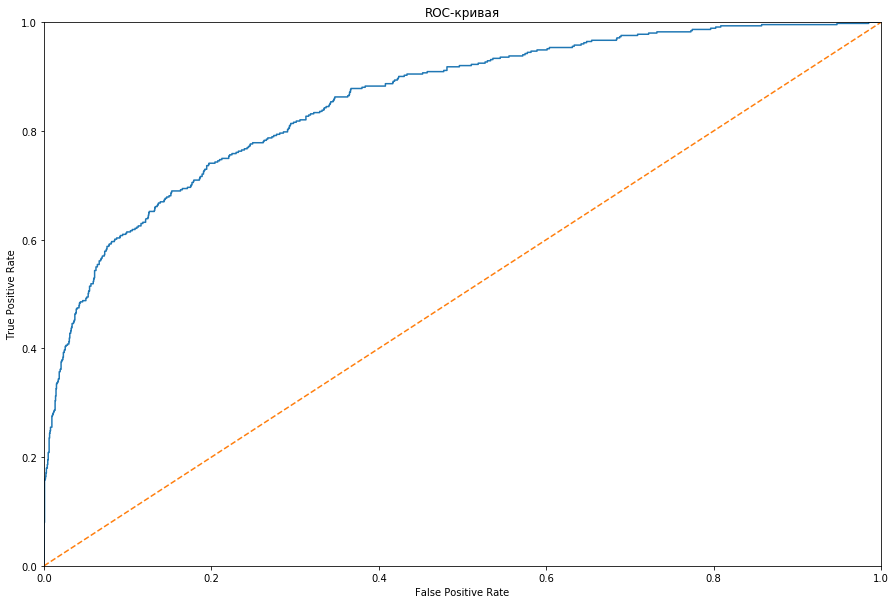

AUC-ROC: 0.85


In [19]:
model_rfc = RandomForestClassifier(**best_params_rfc_balanced)
ml(model_rfc, features_train, target_train, features_valid, target_valid)
roc(model_rfc, features_valid, target_valid)

#### Логистическая регрессия

Подберем для модели наилучшие гиперпараметры.

In [20]:
best_params_lr_balanced = lr_gridsearchcv_balanced(features_train, target_train)
display(best_params_lr_balanced)

{'class_weight': 'balanced',
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'liblinear'}

Точность модели:72.37%
F1-мера: 0.5094


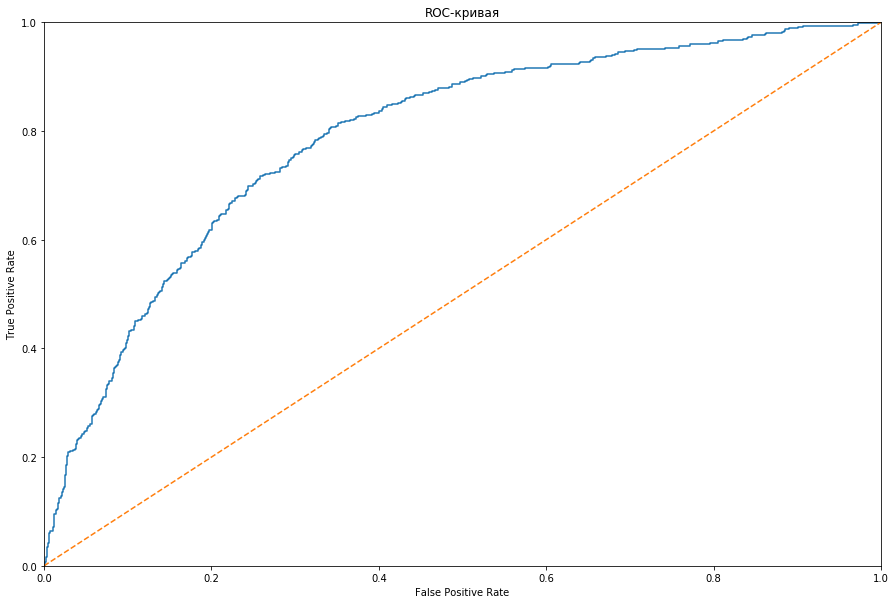

AUC-ROC: 0.79


In [21]:
model_lr = LogisticRegression(**best_params_lr_balanced)
ml(model_lr, features_train, target_train, features_valid, target_valid)
roc(model_lr, features_valid, target_valid)

### 2)  Увеличение выборки

Для того, чтобы сбалнсировать классы увеличим количество объектов в меньшем классе. 

In [22]:
cls_counts = data_enc_train['Exited'].value_counts()
cls_up = int(round(cls_counts[0]/cls_counts[1],4))
cls_down = round(cls_counts[1]/cls_counts[0],4)
print('Необходимо увеличить меньший класс в: {:.0f} раза'. format(cls_up))

Необходимо увеличить меньший класс в: 3 раза


In [23]:
features_upsampled, target_upsampled = upsample(features_train, target_train, cls_up)

#### Случайный лес

Подберем для модели наилучшие гиперпараметры. А затем обучим модель и рассчитаем метрики.

In [24]:
best_params_rfc_upsampled = rfc_gridsearchcv(features_upsampled, target_upsampled)
display(best_params_rfc_upsampled)

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 15,
 'random_state': 12345}

Точность модели:85.39%
F1-мера: 0.6076


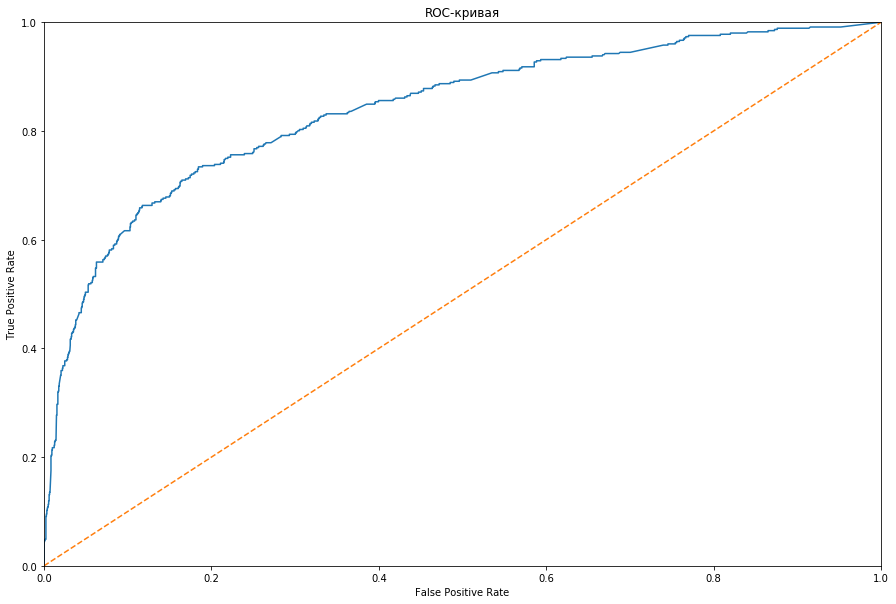

AUC-ROC: 0.84


In [25]:
model_rfc = RandomForestClassifier(**best_params_rfc_upsampled)
ml(model_rfc, features_upsampled, target_upsampled, features_valid, target_valid)
roc(model_rfc, features_valid, target_valid)

#### Логистическая регрессия

Подберем для модели наилучшие гиперпараметры. А затем обучим модель и рассчитаем метрики.

In [26]:
best_params_lr_upsampled = lr_gridsearchcv(features_upsampled, target_upsampled)
display(best_params_lr_upsampled)

{'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear'}

Точность модели:76.51%
F1-мера: 0.5119


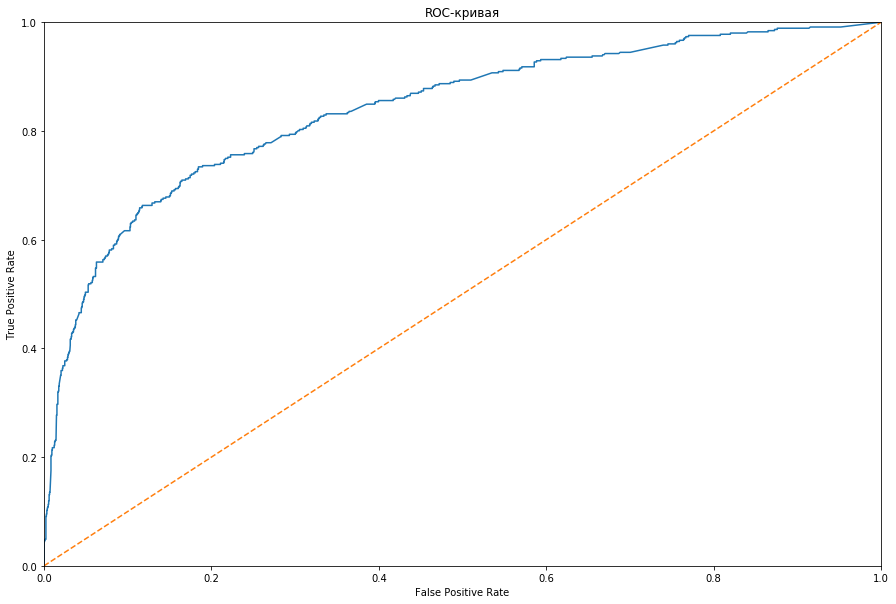

AUC-ROC: 0.84


In [27]:
model_lr = LogisticRegression(**best_params_lr_upsampled)
ml(model_lr, features_upsampled, target_upsampled, features_valid, target_valid)
roc(model_rfc, features_valid, target_valid)

### 3)  Уменьшение выборки

Для того, чтобы сбалнсировать классы уменьшим количество объектов в большем классе. 

In [28]:
features_downsampled, target_downsampled = downsample(features_train, target_train, cls_down)

Проанализируем метрики моделей.

#### Случайный лес

Подберем для модели наилучшие гиперпараметры. А затем обучим модель и рассчитаем метрики.

In [29]:
best_params_rfc_downsampled = rfc_gridsearchcv(features_downsampled, target_downsampled)
display(best_params_rfc_downsampled)

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 13,
 'random_state': 12345}

Точность модели:78.31%
F1-мера: 0.5861


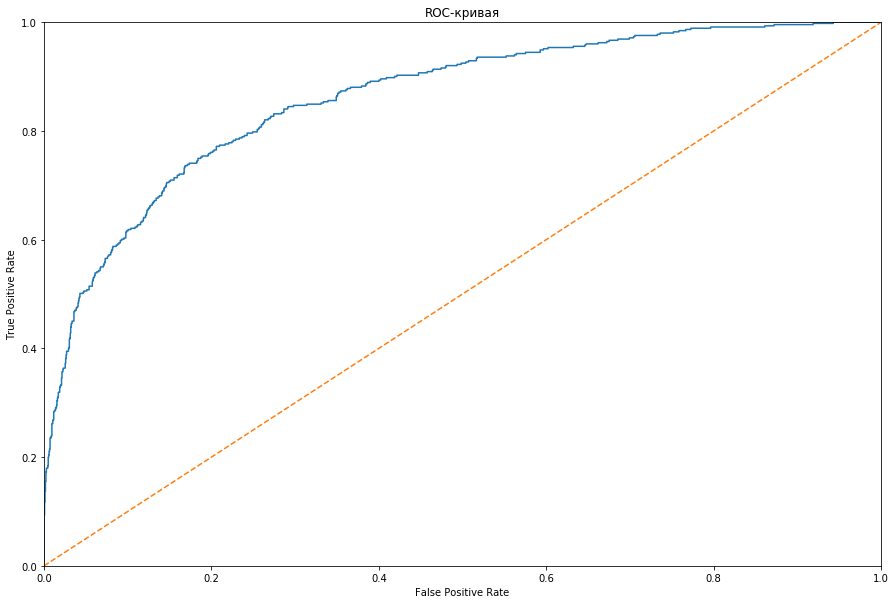

AUC-ROC: 0.86


In [30]:
model_rfc = RandomForestClassifier(**best_params_rfc_downsampled)
ml(model_rfc, features_downsampled, target_downsampled, features_valid, target_valid)
roc(model_rfc, features_valid, target_valid)

#### Логистическая регрессия

Подберем для модели наилучшие гиперпараметры. А затем обучим модель и рассчитаем метрики.

In [31]:
best_params_lr_downsampled = lr_gridsearchcv(features_downsampled, target_downsampled)
display(best_params_lr_downsampled)

{'penalty': 'l1', 'random_state': 12345, 'solver': 'liblinear'}

Точность модели:72.46%
F1-мера: 0.5125


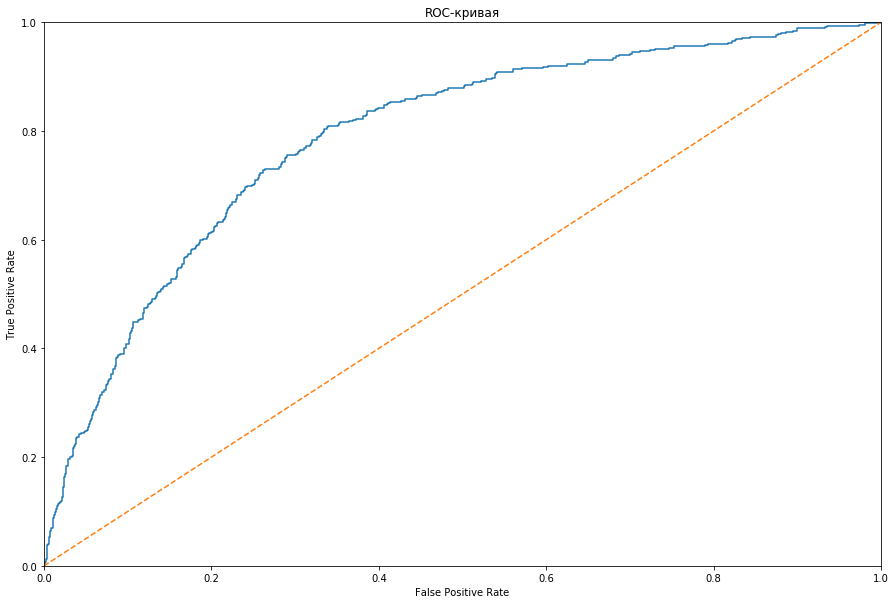

AUC-ROC: 0.79


In [32]:
model_lr = LogisticRegression(**best_params_lr_downsampled)
ml(model_lr, features_downsampled, target_downsampled, features_valid, target_valid)
roc(model_lr, features_valid, target_valid)

### Вывод

По результатам балансирования классов наилучшее прогнозирование показывает модель случайного леса, балансирование классов которой проведено с помощью увеличения выборки.

# 5. Тестирование модели <a id = "5."> </a>

Проведите финальное тестирование.

Точность модели:85.39%
F1-мера: 0.6076


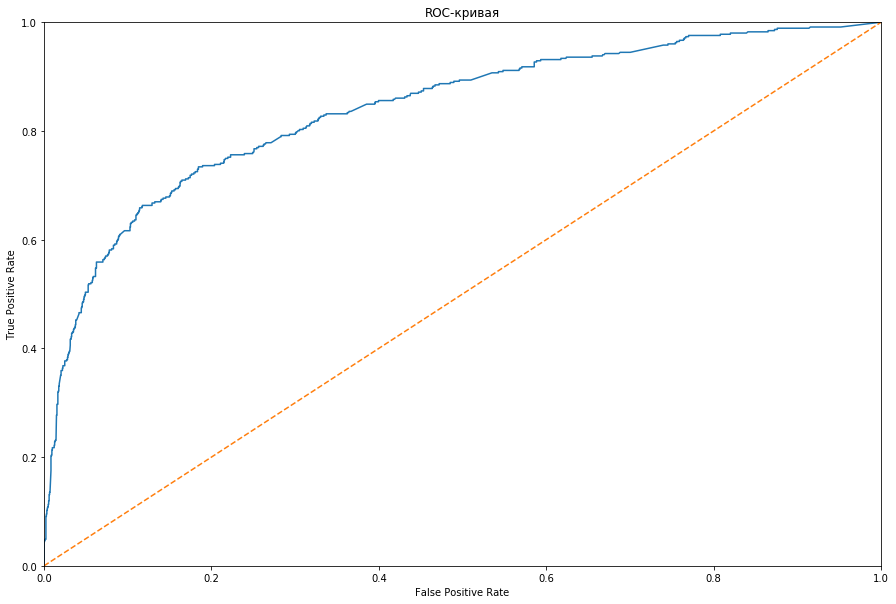

AUC-ROC: 0.84


In [33]:
model_rfc = RandomForestClassifier(**best_params_rfc_upsampled)
ml(model_rfc, features_upsampled, target_upsampled, features_valid, target_valid)
roc(model_rfc, features_valid, target_valid)

### Вывод

Выбранная модель случайного леса показывает высокую точность - 85.39%,  уровень прогнозирования класса выше среднего и составил F1 = 0.6076, что больше 0.59 из условия задачи. ROC-кривая демонстрирует хорошее качество модели (доля истинно положительных ответов больше доли ложноположительных ответов). Площадь фигуры под ROC-кривой составила 0.84, что является хорошим показателем.

## Вывод

Входящие данные были проанализированы. Были удалены избыточные признаки и объекты с пропусками, категориальные признаки были закодированы, а количественные были масштабированы. Для решения задачи классификации были выбраны 2 модели: случайный лес и логистическая регрессия. Для этих модели были подобраны лучшие гиперпараметры. Для борьбы с дисбалансом классов были применены различные методы, в результате были выбран тот, который показывал наилучшую метрику F1 на соответствующей модели. Финальная модель была протестирована, ее метрики были проанализированы.